In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [7]:
#We add the parameters of our planet.
radius, upper_rad_err, lower_rad_err = 1.5353, 0.0333, 0.0324 #Earth Radius
mass, upper_mass_err, lower_mass_err = 6.2059, 1.1861, 1.1700  #Earth Mass
period, upper_per_err, lower_per_err = 0.2241957793, 0.0000000542, 0.0000000553  #Days

In [18]:
#We have to calculate the Insolation Flux of our planet in Earth Flux units.
#To do this we need:
    #Stellar Radius: R_star => In units of Solar Mass
    #Effective Temperature: T_eff => In units of Kelvin
    #Semi-Major Axis: a => In units of AU
#We obtain these values from both ariadne fit and the FCO RV-Transit Joint fit we have conducted.
R_star = 0.651
R_star_err = 0.012
T_eff = 4080
T_eff_err = 77
sma = 0.0063
sma_err = 0.0001

#Now that we have these values, we can obtain the Insolation Flux.
#But to also obtain the errors, we will sample from the posteriors of these parameters.
#For this case, we can sample 10000 samples from the posteriors
R_star_posterior = np.random.normal(0.651, 0.012, 10000)
T_eff_posterior = np.random.normal(4080, 77, 10000)
sma_posterior = np.random.normal(0.0063, 0.0001, 10000)

insolationfluxposterior = (R_star_posterior**2) * (T_eff_posterior/5778)**4 * (1/sma_posterior)**2

insolationfluxposterior

array([2603.0595022 , 2682.20025855, 2676.55460688, ..., 2344.02949672,
       2480.00127694, 2331.21425839])

In [19]:
#We can use the function below to get the Insolation Flux median and errors.
def get_vals(vec, print_result = False, param_name = None):
    fvec   = np.sort(vec)

    fval  = np.median(fvec)
    nn = int(np.around(len(fvec)*0.15865))

    vali,valf = fval - fvec[nn],fvec[-nn] - fval
    
    if print_result == True:
        print(f"{param_name}: {fval:.6f} +{valf:.6f} -{vali:.6f}")
    
    return fval,vali,valf

In [27]:
insolationflux, insolationflux_lower, insolationflux_upper = get_vals(insolationfluxposterior)

print(f"Insolation Flux: {insolationflux:.3f} +{insolationflux_upper:.3f} -{insolationflux_lower:.3f} Earth Flux")

Insolation Flux: 2653.267 +246.406 -230.038 Earth Flux


In [14]:
#Now we import all the planets that have a confirmed mass and radius.
planet_file = '../../data/toi2431_extra/exoplanetdatawithinsolation.csv'
planet_df = pd.read_csv(planet_file, comment = "#")

#We call in the insolation fluxes. (In Earth Flux units)
insol_flux = planet_df["pl_insol"]
insol_flux_err1 = planet_df["pl_insolerr1"] #Upper Error
insol_flux_err2 = planet_df["pl_insolerr2"] #Lower Error

#We also filter out the masses that are not in %33 of the median value i.e. %33 of its own mass.
mass_threshold_pop = 0.33 * planet_df["pl_bmasse"].values

In [ ]:
#We define a function to set boundaries of the Hot Neptune Desert in the Period - Radius Plots.


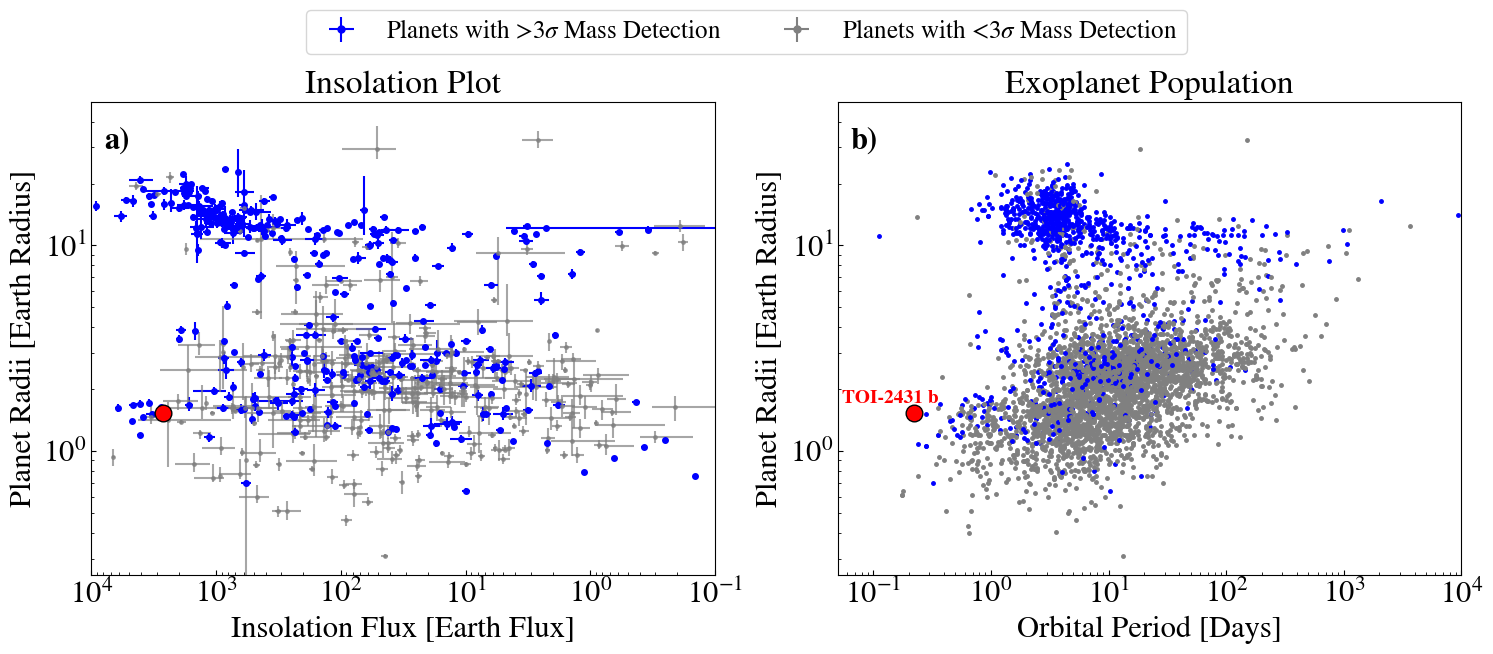

In [51]:
#INSOLATION PLOT

#We create a figure with two subplots side by side (1 row, 2 columns).
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

#--------------------------------- Left Side: Ultra Short Period (USP) Exoplanet Population ---------------------------------
for i, name in enumerate(planet_df["pl_name"]):
    if ((np.abs(planet_df["pl_bmasseerr1"].values[i]) <= mass_threshold_pop[i]) & \
        (np.abs(planet_df["pl_bmasseerr2"].values[i]) <= mass_threshold_pop[i])):
        axs[0].errorbar(planet_df["pl_insol"].values[i], planet_df["pl_rade"].values[i],
                        xerr = [[np.abs(planet_df["pl_insolerr2"].values[i])], [planet_df["pl_insolerr1"].values[i]]], 
                        yerr = [[np.abs(planet_df["pl_radeerr2"].values[i])], [planet_df["pl_radeerr1"].values[i]]],
                        fmt = ".", ms = 8, color = "blue")

    else:
        axs[0].errorbar(planet_df["pl_insol"].values[i], planet_df["pl_rade"].values[i],
                        xerr = [[np.abs(planet_df["pl_insolerr2"].values[i])], [planet_df["pl_insolerr1"].values[i]]], 
                        yerr = [[np.abs(planet_df["pl_radeerr2"].values[i])], [planet_df["pl_radeerr1"].values[i]]],
                        fmt = ".", color = "gray", alpha = 0.7)

axs[0].errorbar(insolationflux, radius, xerr = [[insolationflux_lower], [insolationflux_lower]], 
                yerr = [[lower_rad_err], [upper_rad_err]], fmt = "o", color = "red", 
                ecolor = "orange", capsize = 3, markersize = 12, markeredgecolor = "black", markeredgewidth = 1, zorder = 10000)
#axs[0].text(period-0.040, radius+0.16, "TOI-2431 b", color = "red", weight = "bold", fontsize = 15)

#Adding TOI-6324b into the plot.
# axs[0].errorbar(0.2792210, 1.059, xerr=[[0.00000010], [0.00000010]], 
#                 yerr=[[0.041], [0.041]], fmt="o", color="blue", ms = 8)
#axs[0].text(0.2792210-0.032, 1.059+0.05, "TOI-6324 b", ha='left', va = "bottom", alpha = 0.8, fontsize = 14)

#Adding KOI-1843.03 into the plot.
# axs[0].errorbar(0.1768913, 0.61, xerr=[[0.0000002], [0.0000002]], 
#                 yerr=[[0.08], [0.12]], fmt="o", color="gray")
#axs[0].text(0.1768913-0.005, 0.61-0.010, "KOI-1843.03", ha='right', va = "top", alpha = 0.8, fontsize = 14)

# for i, name in enumerate(planetpop_usp["pl_name"]):
#     if (name == "K2-141 b" or name == "TOI-6255 b" or name == "55 Cnc e" or name == "K2-137 b" or name == "KOI-55 b" or name == "K2-141 b" or
#         name == "K2-22 b"):
#         if name == "TOI-6255 b":
#             axs[0].errorbar(planetpop_usp["pl_orbper"].values[i], planetpop_usp["pl_rade"].values[i],
#                             xerr = [[np.abs(planetpop_usp["pl_orbpererr2"].values[i])], [planetpop_usp["pl_orbpererr1"].values[i]]], 
#                             yerr = [[np.abs(planetpop_usp["pl_radeerr2"].values[i])], [planetpop_usp["pl_radeerr1"].values[i]]],
#                             fmt = "o", color = "blue")
#             axs[0].text(planetpop_usp["pl_orbper"].values[i]-0.004, planetpop_usp["pl_rade"].values[i], name, ha='right', va = "bottom", 
#                         alpha = 0.8, fontsize = 14)
        
#         elif name == "K2-141 b":
#             axs[0].text(planetpop_usp["pl_orbper"].values[i]-0.004, planetpop_usp["pl_rade"].values[i]+0.10, name, ha='left', va = "bottom", 
#                         alpha = 0.8, fontsize = 14)

#         elif name == "K2-137 b":
#             axs[0].text(planetpop_usp["pl_orbper"].values[i]+0.005, planetpop_usp["pl_rade"].values[i]-0.15, name, ha='left', va = "bottom", 
#                         alpha = 0.8, fontsize = 14)

#         elif name == "55 Cnc e":
#             axs[0].text(planetpop_usp["pl_orbper"].values[i]-0.030, planetpop_usp["pl_rade"].values[i]+0.09, name, ha='left', va = "bottom", 
#                         alpha = 0.8, fontsize = 14)

#         elif name == "KOI-55 b":
#             axs[0].text(planetpop_usp["pl_orbper"].values[i]-0.005, planetpop_usp["pl_rade"].values[i], name, ha='right', va = "bottom", 
#                         alpha = 0.8, fontsize = 14)
        
#         else:
#             axs[0].text(planetpop_usp["pl_orbper"].values[i]+0.005, planetpop_usp["pl_rade"].values[i], name, ha='left', va = "bottom", 
#                         alpha = 0.8, fontsize = 14)

#For the legend purposes!!!
axs[0].errorbar(1e7, 1e7, xerr=1e1, yerr=1e1, label = f"Planets with >3$\sigma$ Mass Detection", fmt = "o", color = "blue")
axs[0].errorbar(1e7, 1e7, xerr=1e1, yerr=1e1, label = f"Planets with <3$\sigma$ Mass Detection", fmt = "o", color = "gray")

axs[0].set_xlabel("Insolation Flux [Earth Flux]", fontsize = 22)
axs[0].set_ylabel("Planet Radii [Earth Radius]", fontsize = 22)
axs[0].set_title("Insolation Plot", fontsize = 24)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlim(1e-1, 1e4)
axs[0].set_ylim(0.25, 50)
axs[0].invert_xaxis()
axs[0].tick_params(axis = "x", which = "major", labelsize = 22)
axs[0].tick_params(axis = "x", which = "minor", labelsize = 17)
axs[0].tick_params(axis = "y", which = "major", labelsize = 22)
#axs[0].legend(loc = "upper right", fontsize = 18)
axs[0].text(0.02, 0.90, "a)", transform=axs[0].transAxes, fontsize=22, fontweight="bold")

#--------------------------------- Right Side: Exoplanet Population ---------------------------------
for i, name in enumerate(planet_df["pl_rade"]):
    if ((np.abs(planet_df["pl_bmasseerr1"].values[i]) <= mass_threshold_pop[i]) & \
        (np.abs(planet_df["pl_bmasseerr2"].values[i]) <= mass_threshold_pop[i])):
        axs[1].plot(planet_df["pl_orbper"].values[i], planet_df["pl_rade"].values[i], ".", color = "blue")

    else:
        axs[1].plot(planet_df["pl_orbper"].values[i], planet_df["pl_rade"].values[i], ".", color = "gray")

axs[1].plot(0.2792210, 1.059, ".", color = "blue") #TOI-6324b
axs[1].plot(0.1768913, 0.61, ".", color = "gray") #KOI-1843.03
axs[1].errorbar(period, radius, xerr = [[lower_per_err], [upper_per_err]], 
                yerr = [[lower_rad_err], [upper_rad_err]], fmt = "o", color = "red", 
                ecolor = "orange", capsize = 3, markeredgecolor = "black", markeredgewidth = 1, markersize = 12)
axs[1].text(period-0.170, radius+0.18, "TOI-2431 b", color = "red", weight = "bold", fontsize = 14)
axs[1].set_xlabel("Orbital Period [Days]", fontsize = 22)
axs[1].set_ylabel("Planet Radii [Earth Radius]", fontsize = 22)
axs[1].set_title("Exoplanet Population", fontsize = 24)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlim(0.05, 10000)
axs[1].set_ylim(0.25, 50)
axs[1].tick_params(axis = "x", which = "major", labelsize = 22)
axs[1].tick_params(axis = "y", which = "major", labelsize = 22)
#axs[1].legend(loc = "upper right", fontsize = 15)
axs[1].text(0.02, 0.90, "b)", transform=axs[1].transAxes, fontsize=22, fontweight="bold")

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fancybox=True, fontsize=18)

plt.tight_layout()
#plt.savefig("toi_2431_exoplanet_population.png", dpi = 500, bbox_inches = "tight")
plt.show()